# Importing Libraries

In [1]:
import pandas as pd 
import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
import plotly.express as px

import random
from math import ceil
random.seed(42)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import pickle

In [2]:
train_folder = 'train'
test_folder = 'test'
dataset_folder = 'dataset'

# Loading Data

In [3]:
path_to_incoming_run = os.path.join(dataset_folder, 'incoming_run_data.parquet')
if not os.path.exists(path_to_incoming_run):
    print("File does not exist, creating a new one.")
    incoming_run_files = [f for f in os.listdir(train_folder) if 'incoming_run_data' in f]
    incoming_dataframes = []
    previous_run_id_list = []

    for files in incoming_run_files:
        temp_df = pd.read_parquet(os.path.join(train_folder, files))
        print(temp_df["Tool ID"].unique())

        run_id_list = temp_df["Run ID"].unique().tolist()

        if any(run_id in previous_run_id_list for run_id in run_id_list):
            print("Duplicate Run ID found in previous_run_id_list")
        
        previous_run_id_list.extend(run_id_list)
        incoming_dataframes.append(temp_df)

    incoming_df = pd.concat(incoming_dataframes, ignore_index=True)

    incoming_df.to_parquet('dataset/incoming_run_data.parquet', index=False)
else:
    print("File already exists, loading the existing one.")
    incoming_df = pd.read_parquet(path_to_incoming_run)

incoming_df

File already exists, loading the existing one.


,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Step ID,Time Stamp,Sensor Name,Sensor Value
0,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:00.000000000,Sensor_1,195.469116
1,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:01.000000002,Sensor_1,195.497040
2,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 00:00:01.999999997,Sensor_1,195.497025
3,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 00:00:03.000000000,Sensor_1,195.474823
4,d7291410-f34f-5cee-b3a1-0c60bb854423,2023-12-31 00:00:00,2023-12-31 00:12:22,630ce06e-efcd-5473-9d2a-859f43908b8f,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 00:00:04.000000002,Sensor_1,195.496368
...,...,...,...,...,...,...,...,...,...
82896501,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:09.000000000,Sensor_9,2.702956
82896502,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:10.000000002,Sensor_9,2.957552
82896503,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:10.999999998,Sensor_9,-0.477442
82896504,a060c807-dbdb-5de3-9cd7-0c596234a3d7,2024-01-03 23:43:15,2024-01-03 23:55:50,6908f294-5178-50bc-ba5b-5293435ba574,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-03 23:51:12.000000000,Sensor_9,-1.214340


In [4]:
path_to_run = os.path.join(dataset_folder, 'run_data.parquet')
if not os.path.exists(path_to_run):
    print("File does not exist, creating a new one.")
    run_files = [f for f in os.listdir(train_folder) if 'run_data' in f and 'incoming' not in f]
    run_dataframes = []
    previous_run_id_list = []

    for files in run_files:
        temp_df = pd.read_parquet(os.path.join(train_folder, files))
        print(temp_df["Tool ID"].unique())

        run_id_list = temp_df["Run ID"].unique().tolist()

        if any(run_id in previous_run_id_list for run_id in run_id_list):
            print("Duplicate Run ID found in previous_run_id_list")
        
        previous_run_id_list.extend(run_id_list)
        run_dataframes.append(temp_df)

    run_df = pd.concat(run_dataframes, ignore_index=True)

    run_df.to_parquet('dataset/run_data.parquet', index=False)

else:
    print("File already exists, loading the existing one.")
    run_df = pd.read_parquet(path_to_run)

run_df

File already exists, loading the existing one.


,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Consumable Life,Step ID,Time Stamp,Sensor Name,Sensor Value
0,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_0,2024-01-01 00:00:00.000000000,Sensor_A,-0.024998
1,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_0,2024-01-01 00:00:01.000000002,Sensor_A,0.073171
2,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:01.999999997,Sensor_A,0.070384
3,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:03.000000000,Sensor_A,0.064502
4,30476bd4-f093-56c9-8cd1-23cf7f39ce5f,2024-01-01 00:00:00,2024-01-01 00:12:35,c749278a-b1a4-5062-a57e-45e4946f6b78,22c8716b-1c14-525a-8c0a-0473ec7aa99e,199.290131,Step_1,2024-01-01 00:00:04.000000002,Sensor_A,-0.097807
...,...,...,...,...,...,...,...,...,...,...
41220745,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:06.000000000,Sensor_O,775.952576
41220746,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:07.000000002,Sensor_O,771.639465
41220747,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:07.999999998,Sensor_O,774.632263
41220748,ad28cd71-3811-543c-80a1-a440468a49d7,2024-01-04 04:38:15,2024-01-04 04:50:50,84a6fa0a-721c-576c-97f6-1f5bfe46de4a,22c8716b-1c14-525a-8c0a-0473ec7aa99e,67.854195,Step_12,2024-01-04 04:48:09.000000000,Sensor_O,774.416626


In [5]:
path_to_metrology = os.path.join(dataset_folder, 'metrology_data.parquet')
if not os.path.exists(path_to_metrology):
    print("File does not exist, creating a new one.")
    metrology_files = [f for f in os.listdir(train_folder) if 'metrology_data' in f]

    # Read and concatenate all parquet files
    metrology_dataframes = [pd.read_parquet(os.path.join(train_folder, file)) for file in metrology_files]
    metrology_df = pd.concat(metrology_dataframes, ignore_index=True)

    metrology_df.to_parquet('dataset/metrology_data.parquet', index=False)
else: 
    print("File already exists, loading the existing one.")
    metrology_df = pd.read_parquet(path_to_metrology)

metrology_df

File already exists, loading the existing one.


,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
0,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,23,-143.877551,-9.183673,3,10.104178
1,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,29,-143.877551,27.551020,48,10.064924
2,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,2,34,-137.755102,58.163265,43,10.039947
3,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,3,14,-131.632653,-64.285714,20,10.139306
4,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,5,39,-119.387755,88.775510,8,10.037289
...,...,...,...,...,...,...,...,...,...
202855,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,11,119.387755,-82.653061,5,10.141212
202856,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,39,119.387755,88.775510,22,10.285743
202857,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,46,26,131.632653,9.183673,46,10.305865
202858,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,48,21,143.877551,-21.428571,16,10.325929


# Data Visualisation

In [ ]:
count = 0
incoming_run_id_list = []
unique_tool_ids = incoming_df['Tool ID'].unique()

for tool_id in unique_tool_ids[:6]:  # Limit to first 5 tools for visualization
    # Get first run ID for each tool
    run_id = incoming_df[incoming_df['Tool ID'] == tool_id]['Run ID'].iloc[0]
    incoming_run_id_list.append([tool_id, run_id])

# Get unique sensor names
sensor_names = incoming_df["Sensor Name"].unique()
num_sensors = len(sensor_names)

# Limit to first 6 (tool_id, run_id) pairs for subplots
n_subplots = 6
subplot_pairs = incoming_run_id_list[:n_subplots]

for sensor in sensor_names:
    fig = make_subplots(rows=3, cols=2, subplot_titles=[
        f"Tool: {tool_id}<br>Run: {run_id}" for tool_id, run_id in subplot_pairs
    ])
    
    # Define a color map for steps (consistent across all graphs)
    all_step_ids = sorted(incoming_df["Step ID"].unique(), key=lambda x: int(x.split('_')[-1]))
    color_map = {
        step: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
        for i, step in enumerate(all_step_ids)
    }

    # Track which steps have been added to legend
    legend_steps = set()
    
    for idx, (tool_id, run_id) in enumerate(subplot_pairs):
        temp_df = incoming_df[(incoming_df["Tool ID"] == tool_id) & (incoming_df["Run ID"] == run_id)]
        time_start = temp_df["Time Stamp"].min()
        sensor_df = temp_df[temp_df["Sensor Name"] == sensor]
        
        row = idx // 2 + 1
        col = idx % 2 + 1

        for step in all_step_ids:
            step_data = sensor_df[sensor_df["Step ID"] == step]
            if not step_data.empty:
                time_elapsed = (step_data["Time Stamp"] - time_start).dt.total_seconds()
                
                # Show in legend only if this step hasn't been shown before
                show_legend = step not in legend_steps
                legend_steps.add(step)
                
                fig.add_trace(
                    go.Scatter(
                        x=time_elapsed,
                        y=step_data["Sensor Value"],
                        name=step,
                        mode='lines',
                        line=dict(color=color_map[step]),
                        showlegend=show_legend
                    ),
                    row=row,
                    col=col
                )
    
    fig.update_layout(
        height=1400,
        width=1500,
        title_text=f"Sensor: {sensor} - Comparison Across Tools/Runs",
        showlegend=True
    )

    fig.write_html(os.path.join('plots', 'sensor_readings', f'{sensor}.html'))

    if count < 1:
        fig.show()
        count += 1

In [ ]:
count = 0
run_id_list = []
unique_tool_ids_run = run_df['Tool ID'].unique()

for tool_id in unique_tool_ids_run[:6]:  # Limit to first 5 tools for visualization
    # Get first run ID for each tool
    run_id = run_df[run_df['Tool ID'] == tool_id]['Run ID'].iloc[0]
    run_id_list.append([tool_id, run_id])

# Get unique sensor names
sensor_names = run_df["Sensor Name"].unique()
num_sensors = len(sensor_names)

for sensor in sensor_names:
    fig = make_subplots(rows=3, cols=2, subplot_titles=[
        f"Tool: {tool_id}<br>Run: {run_id}" for tool_id, run_id in subplot_pairs
    ])
    
    # Define a color map for steps (consistent across all graphs)
    all_step_ids = sorted(run_df["Step ID"].unique(), key=lambda x: int(x.split('_')[-1]))
    color_map = {
        step: px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]
        for i, step in enumerate(all_step_ids)
    }

    # Track which steps have been added to legend
    legend_steps = set()
    
    for idx, (tool_id, run_id) in enumerate(subplot_pairs):
        temp_df = run_df[(run_df["Tool ID"] == tool_id) & (run_df["Run ID"] == run_id)]
        time_start = temp_df["Time Stamp"].min()
        sensor_df = temp_df[temp_df["Sensor Name"] == sensor]
        
        row = idx // 2 + 1
        col = idx % 2 + 1

        for step in all_step_ids:
            step_data = sensor_df[sensor_df["Step ID"] == step]
            if not step_data.empty:
                time_elapsed = (step_data["Time Stamp"] - time_start).dt.total_seconds()
                
                # Show in legend only if this step hasn't been shown before
                show_legend = step not in legend_steps
                legend_steps.add(step)
                
                fig.add_trace(
                    go.Scatter(
                        x=time_elapsed,
                        y=step_data["Sensor Value"],
                        name=step,
                        mode='lines',
                        line=dict(color=color_map[step]),
                        showlegend=show_legend
                    ),
                    row=row,
                    col=col
                )
    
    fig.update_layout(
        height=1400,
        width=1500,
        title_text=f"Sensor: {sensor} - Comparison Across Tools/Runs",
        showlegend=True
    )

    fig.write_html(os.path.join('plots', 'sensor_readings', f'{sensor}.html'))

    if count < 1:
        fig.show()
        count += 1

# Data Processing

## 1. Incoming Run Data

### Finding Average Sensor Values

In [6]:
def average_incoming_data(incoming_df):
    tmp_list = []

    temp_grps = [(x[0], x[1], x[2], x[3], y) for x, y in incoming_df.groupby(by=["Tool ID", "Run ID", "Step ID", "Sensor Name"])]
    for temp_grp in temp_grps:
        temp_tool_id = temp_grp[0]
        temp_run_id = temp_grp[1]
        temp_step_id = temp_grp[2]
        temp_sensor_name = temp_grp[3]
        temp_df = temp_grp[4]
        temp_df = temp_df.reset_index()

        temp_run_start_time = temp_df.loc[0, "Run Start Time"]
        temp_run_end_time = temp_df.loc[0, "Run End Time"]
        temp_process_step = temp_df.loc[0, "Process Step"]

        sensor_avgs = temp_df["Sensor Value"].mean()

        temp_time_taken = (temp_df["Time Stamp"].max() - temp_df["Time Stamp"].min()).total_seconds()
        temp_time_taken = int(round(temp_time_taken))
    
        tmp_list.append([
            temp_process_step,
            temp_tool_id,
            temp_run_id,
            temp_run_start_time,
            temp_run_end_time,
            temp_time_taken,
            temp_step_id,
            temp_sensor_name,
            sensor_avgs
        ]) 

    columns = [
        "Process Step",
        "Tool ID",
        "Run ID",
        "Run Start Time",
        "Run End Time",
        "Time Taken (Seconds)",
        "Step ID",
        "Sensor Name",
        "Sensor Value (Average)"
    ] 
    
    incoming_avg_df = pd.DataFrame(tmp_list, columns=columns) 
    del temp_grps
    incoming_avg_df = incoming_avg_df.sort_values(
        by=["Step ID", "Sensor Name"], 
        key=lambda x: x.str.extract(r'_(\d+)')[0].astype(int)
    )

    incoming_avg_df["Test"] = incoming_avg_df["Sensor Name"] + ";" + incoming_avg_df["Step ID"]
    incoming_avg_df = incoming_avg_df.drop(columns=["Step ID", "Sensor Name"])

    return incoming_avg_df

In [ ]:
incoming_avg_df = average_incoming_data(incoming_df)

incoming_avg_df.to_parquet('processed/incoming_avg_df.parquet', index=False)

incoming_avg_df

In [ ]:
incoming_avg_df = pd.read_parquet('processed/incoming_avg_df.parquet')
incoming_avg_df

### Pivot Dataframe

In [7]:
def pivot_incoming_data(incoming_avg_df):    
    dataframe_incoming_pivot = incoming_avg_df.pivot(
        index=["Process Step", "Tool ID", "Run ID", "Run Start Time", "Run End Time"],
        columns="Test",
        values="Sensor Value (Average)"
    ).reset_index()

    return dataframe_incoming_pivot

In [ ]:
dataframe_incoming_pivot = pivot_incoming_data(incoming_avg_df)

dataframe_incoming_pivot.to_parquet('processed/dataframe_incoming_pivot.parquet', index=False)

dataframe_incoming_pivot.sort_values(by=["Run End Time"])

In [8]:
dataframe_incoming_pivot = pd.read_parquet('processed/dataframe_incoming_pivot.parquet')
dataframe_incoming_pivot

,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Sensor_10;Step_0,Sensor_10;Step_1,Sensor_10;Step_2,Sensor_10;Step_3,Sensor_10;Step_4,...,Sensor_8;Step_6,Sensor_8;Step_7,Sensor_9;Step_0,Sensor_9;Step_1,Sensor_9;Step_2,Sensor_9;Step_3,Sensor_9;Step_4,Sensor_9;Step_5,Sensor_9;Step_6,Sensor_9;Step_7
0,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,01081309-698a-5fe2-bedb-ed5361d53e44,2024-01-02 19:13:20,2024-01-02 19:25:52,-0.717782,0.105780,-1.229763,0.362358,-0.796085,...,49.843967,52.319569,65.846077,167.457626,85.583786,91.513435,93.137573,96.425392,47.286938,49.704330
1,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0200b45e-5880-5ae1-aeb1-ccf477621587,2024-01-02 10:35:04,2024-01-02 10:47:36,0.116333,-0.066288,0.573245,0.040695,-0.147506,...,49.717262,52.717896,66.339943,167.596481,100.225281,94.060196,125.436050,96.470551,46.890862,49.445160
2,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,02b1dc7e-9a17-5dde-9912-5adfc694b3fe,2024-01-03 09:37:04,2024-01-03 09:49:36,0.669620,0.297627,-0.001451,-0.349701,-0.714611,...,48.603661,51.183701,66.238304,170.066254,127.010712,125.026291,98.340630,91.325989,47.454681,50.741627
3,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0368c40a-add2-5ad4-830b-64797f18ab03,2024-01-02 12:50:16,2024-01-02 13:02:48,-1.007920,-0.710787,-0.488258,0.061427,0.076361,...,50.021683,53.134987,69.189240,177.174637,102.252190,105.293694,98.445992,101.012596,49.508686,52.632095
4,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0557c0d1-d1e0-5bca-8357-5d68b3b04c40,2024-01-03 00:06:16,2024-01-03 00:18:48,0.502295,-0.012893,0.070695,-0.112466,-0.428260,...,48.782303,50.890831,67.100006,167.037811,92.782669,107.872520,102.954399,100.228340,47.278255,49.712322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fb98e663-3b89-54ac-b4fb-06ea978f77d1,2024-01-01 04:05:00,2024-01-01 04:17:04,636.325623,1713.476440,1530.584106,1315.222046,896.063721,...,47.240269,50.168839,67.170479,175.209244,89.406487,95.484222,101.395477,93.873131,49.349117,51.205452
4136,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fc527315-6998-5c32-9954-c8aefc392fbb,2023-12-31 04:02:44,2023-12-31 04:14:48,450.687836,1602.096924,1432.204956,1230.223145,835.599976,...,50.442642,53.423378,71.034538,178.921249,102.637634,141.484024,132.576050,102.561935,49.583065,52.896065
4137,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fd5ea061-7643-5517-b88c-16ef08b4209b,2023-12-31 03:18:36,2023-12-31 03:30:40,592.113342,1607.630249,1436.826538,1233.409180,837.624451,...,47.157806,49.899780,66.867378,166.772751,95.982834,98.327942,92.504761,91.789108,46.528095,49.020168
4138,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fe6f336c-edcb-5daa-bd28-1c2af7d26418,2024-01-03 14:35:20,2024-01-03 14:47:24,468.215576,1696.745850,1517.500610,1303.144165,885.957458,...,46.940475,49.965549,68.150215,170.712860,102.172752,75.569984,86.284286,105.519714,47.918671,50.583897


## 2. Run Data

### Finding Average Sensor Values

In [9]:
def average_run_data(run_df):
    tmp_list = []

    temp_grps = [(x[0], x[1], x[2], x[3], y) for x, y in run_df.groupby(by=["Tool ID", "Run ID", "Step ID", "Sensor Name"])]
    for temp_grp in temp_grps:
        temp_tool_id = temp_grp[0]
        temp_run_id = temp_grp[1]
        temp_step_id = temp_grp[2]
        temp_sensor_name = temp_grp[3]
        temp_df = temp_grp[4]
        temp_df = temp_df.reset_index()

        temp_run_start_time = temp_df.loc[0, "Run Start Time"]
        temp_run_end_time = temp_df.loc[0, "Run End Time"]
        temp_process_step = temp_df.loc[0, "Process Step"]
        temp_consumable_life = temp_df.loc[0, "Consumable Life"]

        sensor_avgs = temp_df["Sensor Value"].mean()

        temp_time_taken = (temp_df["Time Stamp"].max() - temp_df["Time Stamp"].min()).total_seconds()
        temp_time_taken = int(round(temp_time_taken))
    
        tmp_list.append([
            temp_process_step,
            temp_tool_id,
            temp_run_id,
            temp_run_start_time,
            temp_run_end_time,
            temp_time_taken,
            temp_consumable_life,
            temp_step_id,
            temp_sensor_name,
            sensor_avgs
        ]) 

    columns = [
        "Process Step",
        "Tool ID",
        "Run ID",
        "Run Start Time",
        "Run End Time",
        "Time Taken (Seconds)",
        "Consumable Life",
        "Step ID",
        "Sensor Name",
        "Sensor Value (Average)"
    ] 
    
    run_avg_df = pd.DataFrame(tmp_list, columns=columns) 
    del temp_grps
    run_avg_df = run_avg_df.sort_values(
        by=["Step ID"], 
        key=lambda x: x.str.extract(r'Step_(\d+)')[0].astype(int)
    )

    run_avg_df["Test"] = run_avg_df["Sensor Name"] + ";" + run_avg_df["Step ID"]
    run_avg_df = run_avg_df.drop(columns=["Step ID", "Sensor Name"])

    return run_avg_df

In [ ]:
run_avg_df = average_run_data(run_df)

run_avg_df.to_parquet('processed/run_avg_df.parquet', index=False)

run_avg_df

In [ ]:
run_avg_df = pd.read_parquet('processed/run_avg_df.parquet')
run_avg_df.sort_values(by=["Run ID"])

### Pivot Dataframe

In [10]:
def pivot_run_data(run_avg_df):
    dataframe_run_pivot = run_avg_df.pivot(
        index=["Process Step", "Tool ID", "Run ID", "Run Start Time", "Run End Time", "Consumable Life"],
        columns="Test",
        values="Sensor Value (Average)"
    ).reset_index()

    return dataframe_run_pivot

In [ ]:
dataframe_run_pivot = pivot_run_data(run_avg_df)

dataframe_run_pivot.to_parquet('processed/dataframe_run_pivot.parquet', index=False)

dataframe_run_pivot.sort_values(by=["Run End Time"])

In [11]:
dataframe_run_pivot = pd.read_parquet('processed/dataframe_run_pivot.parquet')
dataframe_run_pivot

,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Consumable Life,Sensor_A;Step_0,Sensor_A;Step_1,Sensor_A;Step_10,Sensor_A;Step_11,...,Sensor_O;Step_11,Sensor_O;Step_12,Sensor_O;Step_2,Sensor_O;Step_3,Sensor_O;Step_4,Sensor_O;Step_5,Sensor_O;Step_6,Sensor_O;Step_7,Sensor_O;Step_8,Sensor_O;Step_9
0,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,01081309-698a-5fe2-bedb-ed5361d53e44,2024-01-03 06:02:05,2024-01-03 06:14:40,238.591507,0.046524,0.017834,-0.005643,-0.017041,...,850.726990,712.921143,932.698242,981.100830,1034.891724,1035.301025,1035.496216,1035.480591,1034.948975,995.814087
1,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0200b45e-5880-5ae1-aeb1-ccf477621587,2024-01-02 23:17:40,2024-01-02 23:30:15,227.375107,0.000422,0.009372,-0.000722,0.006000,...,993.964417,811.710693,1103.434204,1145.991699,1208.872803,1209.182373,1209.093872,1209.176514,1209.127563,1163.668945
2,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,02b1dc7e-9a17-5dde-9912-5adfc694b3fe,2024-01-03 17:47:40,2024-01-03 18:00:15,382.248169,0.002449,-0.003345,0.002199,0.013677,...,896.450500,722.920471,996.757751,1027.515747,1084.831299,1083.625854,1082.095093,1081.702393,1080.035400,1040.857300
3,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0368c40a-add2-5ad4-830b-64797f18ab03,2024-01-03 01:03:10,2024-01-03 01:15:45,280.875458,-0.030572,0.000560,0.016004,-0.001965,...,1004.501221,837.388733,1104.948364,1158.827271,1222.506836,1222.504150,1222.448608,1222.479736,1222.691895,1176.614990
4,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,0557c0d1-d1e0-5bca-8357-5d68b3b04c40,2024-01-03 09:50:40,2024-01-03 10:03:15,387.216370,0.054034,0.003133,-0.000183,0.006873,...,925.269470,754.677551,1027.495117,1066.565796,1125.359741,1125.725220,1125.772339,1125.671875,1125.853027,1083.477173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4135,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fb98e663-3b89-54ac-b4fb-06ea978f77d1,2024-01-01 22:53:45,2024-01-01 23:06:20,358.579987,-0.015601,0.003888,-0.009120,0.012936,...,958.252991,777.652771,1067.435547,1105.008179,1165.996582,1165.871216,1166.180664,1165.542969,1165.878662,1122.154297
4136,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fc527315-6998-5c32-9954-c8aefc392fbb,2024-01-01 03:13:25,2024-01-01 03:26:00,289.503723,0.006762,-0.005030,0.000329,-0.004495,...,1061.687134,882.525452,1168.113159,1224.476807,1292.155396,1292.088257,1291.382202,1292.072266,1291.906250,1242.978882
4137,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fd5ea061-7643-5517-b88c-16ef08b4209b,2024-01-01 02:38:15,2024-01-01 02:50:50,429.743866,-0.047434,0.006374,0.011318,-0.001996,...,974.559692,790.916443,1085.240601,1123.280762,1185.529785,1185.403564,1185.620483,1185.818848,1185.365601,1140.412720
4138,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,fe6f336c-edcb-5daa-bd28-1c2af7d26418,2024-01-03 23:04:10,2024-01-03 23:16:45,272.015472,-0.076994,0.002362,0.014019,-0.021124,...,946.736145,788.289917,1041.276245,1091.769897,1151.744751,1151.923462,1151.686646,1152.145264,1151.805664,1108.576416


## 3. Merging Data

In [12]:
def merge_dataframes(metrology_df, dataframe_run_pivot, dataframe_incoming_pivot):
    final_df = pd.DataFrame()
    unique_run_ids = metrology_df["Run ID"].unique().tolist()

    for run_id in unique_run_ids:
        temp_metrology_df = metrology_df[metrology_df["Run ID"] == run_id].reset_index(drop=True)
        temp_run_df = dataframe_run_pivot[dataframe_run_pivot["Run ID"] == run_id].reset_index(drop=True)
        temp_incoming_df = dataframe_incoming_pivot[dataframe_incoming_pivot["Run ID"] == run_id].reset_index(drop=True)

        temp_incoming_df = temp_incoming_df.drop(columns=["Run Start Time", "Run End Time"])

        if temp_run_df.empty:
            print(f"Run ID {run_id} not found in run data.")
            continue

        if temp_incoming_df.empty:
            print(f"Run ID {run_id} not found in incoming data.")
            continue

        for _, metrology_row in temp_metrology_df.iterrows():
            # Convert row Series to single-row DataFrame
            metrology_row_df = pd.DataFrame([metrology_row])
            
            # Merge with corresponding run data
            merge_1 = pd.merge(
                metrology_row_df,
                temp_run_df,
                how="left",
                on=["Run ID", "Run Start Time", "Run End Time"]
            )

            merge_2 = pd.merge(
                merge_1,
                temp_incoming_df,
                how="left",
                on=["Process Step", "Tool ID", "Run ID"]
            )

            # Append to the result DataFrame
            final_df = pd.concat([final_df, merge_2], ignore_index=True)

    return final_df

In [ ]:
final_df = merge_dataframes(metrology_df, dataframe_run_pivot, dataframe_incoming_pivot)

final_df.to_parquet('processed/final_df.parquet', index=False)

In [81]:
final_df = pd.read_parquet('processed/final_df.parquet')
final_df

,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement,Process Step,...,Sensor_8;Step_6,Sensor_8;Step_7,Sensor_9;Step_0,Sensor_9;Step_1,Sensor_9;Step_2,Sensor_9;Step_3,Sensor_9;Step_4,Sensor_9;Step_5,Sensor_9;Step_6,Sensor_9;Step_7
0,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,23,-143.877551,-9.183673,3,10.104178,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.465588,52.934277,41.957478,147.698120,91.161613,131.187378,102.621956,103.496384,50.521515,52.957142
1,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,1,29,-143.877551,27.551020,48,10.064924,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.465588,52.934277,41.957478,147.698120,91.161613,131.187378,102.621956,103.496384,50.521515,52.957142
2,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,2,34,-137.755102,58.163265,43,10.039947,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.465588,52.934277,41.957478,147.698120,91.161613,131.187378,102.621956,103.496384,50.521515,52.957142
3,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,3,14,-131.632653,-64.285714,20,10.139306,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.465588,52.934277,41.957478,147.698120,91.161613,131.187378,102.621956,103.496384,50.521515,52.957142
4,00970470-f2f4-5759-86c4-f31fe6abdc5a,2024-01-01 04:41:20,2024-01-01 04:53:55,5,39,-119.387755,88.775510,8,10.037289,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.465588,52.934277,41.957478,147.698120,91.161613,131.187378,102.621956,103.496384,50.521515,52.957142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202855,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,11,119.387755,-82.653061,5,10.141212,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.780426,52.448387,26.414335,126.463196,128.279694,126.784653,99.408722,95.193443,48.490456,51.097870
202856,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,44,39,119.387755,88.775510,22,10.285743,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.780426,52.448387,26.414335,126.463196,128.279694,126.784653,99.408722,95.193443,48.490456,51.097870
202857,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,46,26,131.632653,9.183673,46,10.305865,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.780426,52.448387,26.414335,126.463196,128.279694,126.784653,99.408722,95.193443,48.490456,51.097870
202858,ff189126-dd33-50b0-8eea-5bab9318b543,2024-01-01 11:43:20,2024-01-01 11:55:55,48,21,143.877551,-21.428571,16,10.325929,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.780426,52.448387,26.414335,126.463196,128.279694,126.784653,99.408722,95.193443,48.490456,51.097870


# Data Splitting

Since we want to generalise across tools, we will split by tool ID 

In [4]:
target = 'Measurement'
non_features = ["Run ID", "Run Start Time", "Run End Time", "X_index", "Y_index", "Point Index", "Process Step", "Tool ID"]

selected_features = [col for col in final_df.columns if col not in [target] + non_features]
print(selected_features)
print(len(selected_features))

['X', 'Y', 'Consumable Life', 'Sensor_A;Step_0', 'Sensor_A;Step_1', 'Sensor_A;Step_10', 'Sensor_A;Step_11', 'Sensor_A;Step_12', 'Sensor_A;Step_2', 'Sensor_A;Step_3', 'Sensor_A;Step_4', 'Sensor_A;Step_5', 'Sensor_A;Step_6', 'Sensor_A;Step_7', 'Sensor_A;Step_8', 'Sensor_A;Step_9', 'Sensor_B;Step_0', 'Sensor_B;Step_1', 'Sensor_B;Step_10', 'Sensor_B;Step_11', 'Sensor_B;Step_12', 'Sensor_B;Step_2', 'Sensor_B;Step_3', 'Sensor_B;Step_4', 'Sensor_B;Step_5', 'Sensor_B;Step_6', 'Sensor_B;Step_7', 'Sensor_B;Step_8', 'Sensor_B;Step_9', 'Sensor_C;Step_0', 'Sensor_C;Step_1', 'Sensor_C;Step_10', 'Sensor_C;Step_11', 'Sensor_C;Step_12', 'Sensor_C;Step_2', 'Sensor_C;Step_3', 'Sensor_C;Step_4', 'Sensor_C;Step_5', 'Sensor_C;Step_6', 'Sensor_C;Step_7', 'Sensor_C;Step_8', 'Sensor_C;Step_9', 'Sensor_D;Step_0', 'Sensor_D;Step_1', 'Sensor_D;Step_10', 'Sensor_D;Step_11', 'Sensor_D;Step_12', 'Sensor_D;Step_2', 'Sensor_D;Step_3', 'Sensor_D;Step_4', 'Sensor_D;Step_5', 'Sensor_D;Step_6', 'Sensor_D;Step_7', 'Sensor_

In [5]:
tool_id_list = final_df["Tool ID"].unique().tolist()
validation_id_list = random.sample(tool_id_list, k=ceil(len(tool_id_list) * 0.2))
train_id_list = list(set(tool_id_list) - set(validation_id_list))

print("Number of Tool IDs used for training:", len(train_id_list))
print("Number of Tool IDs used for validation:", len(validation_id_list))

Number of Tool IDs used for training: 15
Number of Tool IDs used for validation: 4


In [6]:
train_df = final_df[final_df["Tool ID"].isin(train_id_list)].reset_index()
validation_df = final_df[final_df["Tool ID"].isin(validation_id_list)].reset_index()

print("Length of training data:", len(train_df))
print("Length of validation data:", len(validation_df))

Length of training data: 158760
Length of validation data: 44100


In [7]:
X_train = train_df[selected_features]
y_train = train_df[target]

X_validation = validation_df[selected_features]
y_validation = validation_df[target]

print("X train shape:", X_train.shape)
print("y train shape:", y_train.shape)

print("X validate shape:", X_validation.shape)
print("y validate shape:", y_validation.shape)

X train shape: (158760, 526)
y train shape: (158760,)
X validate shape: (44100, 526)
y validate shape: (44100,)


# Feature Selection

## Extra Trees Feature Importance 

Selected Features: ['X' 'Y' 'Sensor_N;Step_1' 'Sensor_N;Step_11' 'Sensor_N;Step_5'
 'Sensor_N;Step_8' 'Sensor_I;Step_1' 'Sensor_N;Step_7' 'Sensor_I;Step_2'
 'Sensor_N;Step_6' 'Sensor_N;Step_9' 'Sensor_I;Step_11' 'Sensor_I;Step_9'
 'Sensor_N;Step_2' 'Sensor_N;Step_4' 'Sensor_B;Step_9' 'Sensor_I;Step_3'
 'Sensor_I;Step_6' 'Sensor_I;Step_4' 'Sensor_I;Step_8' 'Sensor_B;Step_4'
 'Sensor_N;Step_0' 'Sensor_N;Step_10' 'Sensor_I;Step_5' 'Sensor_I;Step_7'
 'Sensor_I;Step_10' 'Sensor_K;Step_2' 'Sensor_M;Step_1' 'Sensor_M;Step_5'
 'Sensor_H;Step_4' 'Sensor_M;Step_9' 'Sensor_E;Step_2' 'Sensor_M;Step_2'
 'Sensor_M;Step_8' 'Sensor_M;Step_7' 'Sensor_M;Step_4' 'Sensor_H;Step_1'
 'Sensor_H;Step_11' 'Sensor_M;Step_3' 'Sensor_H;Step_8' 'Sensor_G;Step_5'
 'Sensor_M;Step_11' 'Sensor_1;Step_6' 'Sensor_G;Step_4' 'Sensor_1;Step_5'
 'Consumable Life']


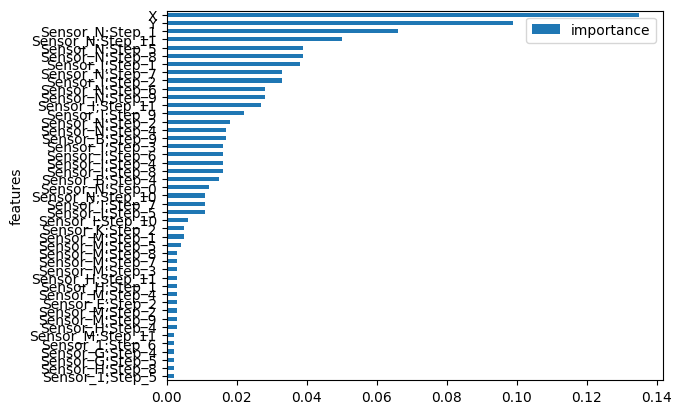

In [8]:
def extra_trees_feature_selection(X, y, top_k: int = 45):
    model = ExtraTreesRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    feature_importances = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'features': X.columns,
        'importance': feature_importances
    }).sort_values(by='importance', ascending=False).reset_index(drop=True).round(3).head(top_k)
    
    selected_features = importance_df['features'].values
    
    return selected_features, importance_df

selected_features, top_k_df = extra_trees_feature_selection(X_train, y_train, top_k=45)
length = len(selected_features)

additional_features = ['X', 'Y', 'Consumable Life']
for feature in additional_features:
    if feature not in selected_features:
        selected_features = np.append(selected_features, feature)

print("Selected Features:", selected_features)

X_train = X_train[selected_features]
X_validation = X_validation[selected_features]

selected_features = selected_features.tolist()
with open(f'Extra_Trees_feature_selection.txt', 'w') as f:
    for feature in selected_features:
        f.write(f"{feature}\n")

top_k_df.sort_values(by='importance', ascending=True).plot.barh(y='importance', x='features')
plt.savefig(f'plots/feature_importance_extra_trees-{length}.png', bbox_inches='tight')

## Select K Best

In [ ]:
# def select_k_best_regression(X, Y, top_k: int = 40):
#     model = SelectKBest(score_func=f_regression, k=top_k)  
#     model.fit(X, Y)
#     scores = model.scores_
#     col_names = X.columns

#     score_df = pd.DataFrame({
#         'features': col_names,
#         'scores': scores
#     }).sort_values(by='scores', ascending=False).reset_index(drop=True).round(3)

#     selected_features = score_df.head(top_k)['features'].values
#     return selected_features, score_df.head(top_k)

# selected_features, top_k_df = select_k_best_regression(final_df[selected_features], final_df[target], top_k=100)

# additional_features = ['X', 'Y', 'Consumable Life']
# for feature in additional_features:
#     if feature not in selected_features:
#         selected_features = np.append(selected_features, feature)

# print("Final Selected Features:", len(selected_features))

# print("Selected Features:", selected_features)
# top_k_df.sort_values(by='scores', ascending=True).plot.barh(y='scores', x='features')

## PCA 

In [ ]:
# scaler = StandardScaler()
# feature_scaled = scaler.fit_transform(final_df[selected_features])

# pca_selected_feature = PCA(n_components=len(selected_features))
# pca_selected_feature.fit(feature_scaled)

# explained_variance = pca_selected_feature.explained_variance_ratio_ * 100

# plt.figure(figsize=(12, 6))
# plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--', color='black')
# plt.xlabel('Principal Component')

# for i, value in enumerate(explained_variance, start=1):
#     plt.text(i + 1, value + 0.5, f"{value:.1f}%", ha='center', fontsize=8)

# plt.ylabel('Explained Variance (%)')
# plt.title('PCA Scree Plot')
# plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='teal', label='Percentage')

# plt.xticks(range(1, len(explained_variance) + 1, 1))

# plt.grid(True)
# plt.legend()

# plt.savefig('plots/pca_scree_plot.png', bbox_inches='tight')
# plt.show()

In [ ]:
# variance = pca_selected_feature.explained_variance_ratio_ * 100
# cumulative_variance = np.cumsum(variance)

# min_pc = np.argmax(cumulative_variance >= 80) + 1

# print(f"Minimum number of principal components to explain 80% variance: {min_pc}")

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(final_df[selected_features])

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot for regression
fig = px.scatter(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    color=final_df[target],  # Continuous color
    title='PCA 2D Projection (Colored by Target Value)',
    labels={'x': 'PC 1', 'y': 'PC 2', 'color': 'Target'},
    color_continuous_scale='Viridis'  # or 'Plasma', 'Cividis', 'Turbo', etc.
)
fig.write_html(f'plots/pca_scatter_plot-{len(selected_features)}.html')
fig.show()

# Model Building and Training

## Models

### 1. Linear Regression

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validation)

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_validate_scaled)

### 2. Extra Trees Regressor

In [9]:
et_model = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=20,
    criterion='squared_error',
    random_state=42,
    bootstrap=True
)

et_model.fit(X_train, y_train)
y_pred_et = et_model.predict(X_validation)

### 3. Multi Layer Perceptron

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validate_scaled = scaler.transform(X_validation)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_validate_scaled)

## Model Initial Evaluation

### Comparing Model Performance 

In [10]:
print(X_train.shape)

(158760, 46)


In [11]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# evaluate_model("Linear Regression", y_validation, y_pred_lr)
evaluate_model("Extra Trees Regressor", y_validation, y_pred_et)
# evaluate_model("Multi Layer Perceptron", y_validation, y_pred_mlp)


Extra Trees Regressor Evaluation:
R² Score: 0.9217
RMSE: 0.0489


### Error Distribution Plot

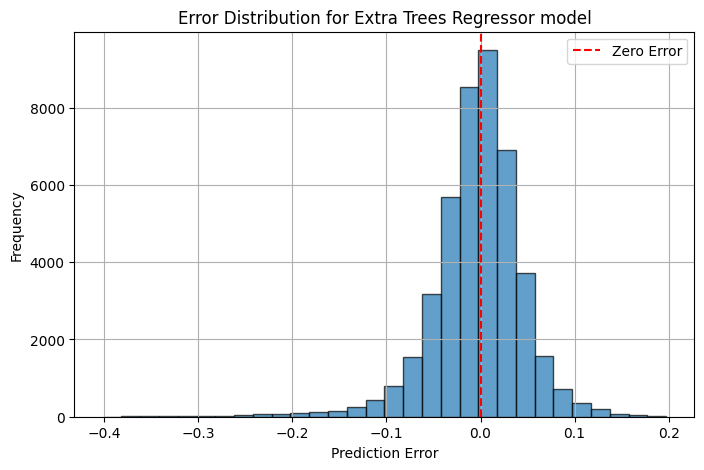

In [12]:
predictions = {
    # 'Linear Regression': y_pred_lr,
    'Extra Trees Regressor': y_pred_et,
    # 'Multi Layer Perceptron': y_pred_mlp
}

for name, preds in predictions.items():
    error = preds - y_validation

    plt.figure(figsize=(8, 5))
    plt.hist(error, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Error Distribution for {name} model")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"plots/error_distribution_{name}-{len(selected_features)}.png")
    plt.show()

### REC Curve (Regression Error Characteristic)

In [ ]:

# Plot the REC curve for all models on the same graph
plt.figure(figsize=(10, 6))

for name, preds in predictions.items():
    abs_errors = np.abs(preds - y_validation)
    sorted_errors = np.sort(abs_errors)
    coverage = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, coverage, label=name)

plt.xlabel("Error Tolerance (ε)")
plt.ylabel("Fraction of Samples with Error ≤ ε")
plt.title(f"Regression Error Characteristic (REC) Curves for {len(selected_features)}")
plt.grid(True)
plt.legend()
plt.savefig("plots/rec_curves.png")
plt.show()

# Model Optimisation

## Optuna Tuning

Doing optimisation for the best model

In [ ]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    model = ExtraTreesRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=bootstrap,
        random_state=42,
    )

    score = cross_val_score(model, X_train, y_train, cv=5, scoring=scorer).mean()
    return score

study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=25)

best_params = study.best_trial.params

print("Best trial:", best_params)

In [ ]:
best_model = ExtraTreesRegressor(
    **best_params,
    random_state=42
)

In [14]:
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_validation)

evaluate_model("Optimized Extra Trees Regressor", y_validation, y_pred_best)
evaluate_model("Extra Trees Regressor", y_validation, y_pred_et)


Optimized Extra Trees Regressor Evaluation:
R² Score: 0.9255
RMSE: 0.0477

Extra Trees Regressor Evaluation:
R² Score: 0.9217
RMSE: 0.0489


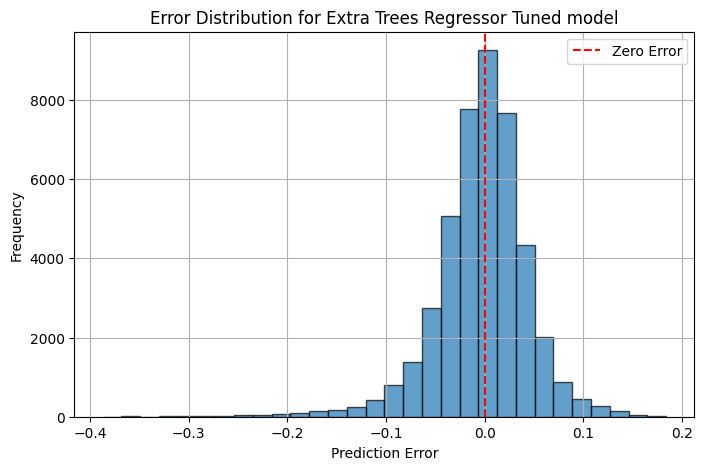

In [15]:
predictions = {'Extra Trees Regressor Tuned': y_pred_best}

for name, preds in predictions.items():
    error = preds - y_validation

    plt.figure(figsize=(8, 5))
    plt.hist(error, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"Error Distribution for {name} model")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.axvline(x=0, color='red', linestyle='--', label='Zero Error')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"plots/error_distribution_{name}-{len(selected_features)}.png")
    plt.show()

In [ ]:
with open(f'best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Model Results on Test Set

## Loading data

In [13]:
incoming_test_df = pd.read_parquet('test/incoming_run_data.parquet')
incoming_test_df

,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Step ID,Time Stamp,Sensor Name,Sensor Value
674983,c7f536aa-a2fc-54b4-9b98-9f01793c9b5d,2023-12-31 12:23:03,2023-12-31 12:35:34,91fda3be-c5f4-50a9-9ee8-d358d2413cbd,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 12:23:03.000000000,Sensor_1,200.572800
674984,c7f536aa-a2fc-54b4-9b98-9f01793c9b5d,2023-12-31 12:23:03,2023-12-31 12:35:34,91fda3be-c5f4-50a9-9ee8-d358d2413cbd,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_0,2023-12-31 12:23:04.000000002,Sensor_1,200.562149
674985,c7f536aa-a2fc-54b4-9b98-9f01793c9b5d,2023-12-31 12:23:03,2023-12-31 12:35:34,91fda3be-c5f4-50a9-9ee8-d358d2413cbd,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 12:23:04.999999997,Sensor_1,200.591949
674986,c7f536aa-a2fc-54b4-9b98-9f01793c9b5d,2023-12-31 12:23:03,2023-12-31 12:35:34,91fda3be-c5f4-50a9-9ee8-d358d2413cbd,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 12:23:06.000000000,Sensor_1,200.561356
674987,c7f536aa-a2fc-54b4-9b98-9f01793c9b5d,2023-12-31 12:23:03,2023-12-31 12:35:34,91fda3be-c5f4-50a9-9ee8-d358d2413cbd,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_1,2023-12-31 12:23:07.000000002,Sensor_1,200.566467
...,...,...,...,...,...,...,...,...,...
3008124,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 09:02:26,2024-01-02 09:15:00,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-02 09:10:36.000000002,Sensor_9,0.884480
3008125,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 09:02:26,2024-01-02 09:15:00,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-02 09:10:36.999999998,Sensor_9,1.950284
3008126,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 09:02:26,2024-01-02 09:15:00,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-02 09:10:38.000000000,Sensor_9,2.874060
3008127,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 09:02:26,2024-01-02 09:15:00,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,Step_7,2024-01-02 09:10:39.000000002,Sensor_9,-1.415304


In [42]:
run_test_df = pd.read_parquet('test/run_data.parquet')
run_test_df

,Tool ID,Run Start Time,Run End Time,Run ID,Process Step,Consumable Life,Step ID,Time Stamp,Sensor Name,Sensor Value
0,683e5405-4b93-5160-be90-d3d5b0d9287a,2024-01-01 01:27:55,2024-01-01 01:40:30,dac9d86d-8006-5bcf-a10d-dc575bca05fb,22c8716b-1c14-525a-8c0a-0473ec7aa99e,115.641464,Step_0,2024-01-01 01:27:55.000000000,Sensor_A,0.055712
1,683e5405-4b93-5160-be90-d3d5b0d9287a,2024-01-01 01:27:55,2024-01-01 01:40:30,dac9d86d-8006-5bcf-a10d-dc575bca05fb,22c8716b-1c14-525a-8c0a-0473ec7aa99e,115.641464,Step_0,2024-01-01 01:27:56.000000002,Sensor_A,-0.114435
2,683e5405-4b93-5160-be90-d3d5b0d9287a,2024-01-01 01:27:55,2024-01-01 01:40:30,dac9d86d-8006-5bcf-a10d-dc575bca05fb,22c8716b-1c14-525a-8c0a-0473ec7aa99e,115.641464,Step_0,2024-01-01 01:27:56.999999997,Sensor_A,0.030820
3,683e5405-4b93-5160-be90-d3d5b0d9287a,2024-01-01 01:27:55,2024-01-01 01:40:30,dac9d86d-8006-5bcf-a10d-dc575bca05fb,22c8716b-1c14-525a-8c0a-0473ec7aa99e,115.641464,Step_1,2024-01-01 01:27:58.000000000,Sensor_A,-0.066958
4,683e5405-4b93-5160-be90-d3d5b0d9287a,2024-01-01 01:27:55,2024-01-01 01:40:30,dac9d86d-8006-5bcf-a10d-dc575bca05fb,22c8716b-1c14-525a-8c0a-0473ec7aa99e,115.641464,Step_1,2024-01-01 01:27:59.000000002,Sensor_A,0.011077
...,...,...,...,...,...,...,...,...,...,...
8557225,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 21:29:55,2024-01-02 21:42:30,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,279.218048,Step_12,2024-01-02 21:41:14.000000002,Sensor_O,690.403748
8557226,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 21:29:55,2024-01-02 21:42:30,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,279.218048,Step_12,2024-01-02 21:41:14.999999998,Sensor_O,750.969604
8557227,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 21:29:55,2024-01-02 21:42:30,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,279.218048,Step_12,2024-01-02 21:41:16.000000000,Sensor_O,690.931152
8557228,1b314ddd-198a-5cd5-90ae-933b947d013d,2024-01-02 21:29:55,2024-01-02 21:42:30,e195334c-cfb1-5297-b3e2-7f7a33c48a97,22c8716b-1c14-525a-8c0a-0473ec7aa99e,279.218048,Step_12,2024-01-02 21:41:17.000000002,Sensor_O,746.828857


In [65]:
metrology_test_df = pd.read_parquet('submission/metrology_data.parquet')
metrology_test_df

,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
0,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,23,-143.877551,-9.183673,3,NaN
1,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,29,-143.877551,27.551020,48,NaN
2,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,2,34,-137.755102,58.163265,43,NaN
3,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,3,14,-131.632653,-64.285714,20,NaN
4,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,5,39,-119.387755,88.775510,8,NaN
...,...,...,...,...,...,...,...,...,...
42135,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,11,119.387755,-82.653061,5,NaN
42136,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,39,119.387755,88.775510,22,NaN
42137,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,46,26,131.632653,9.183673,46,NaN
42138,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,48,21,143.877551,-21.428571,16,NaN


## Data Processing

### Removing repeated data

In [45]:
incoming_run_id_list = incoming_df["Run ID"].unique().tolist()
incoming_run_id_list_test = incoming_test_df["Run ID"].unique().tolist()
same_incoming = set(incoming_run_id_list_test) & set(incoming_run_id_list)
print(len(same_incoming))

90


In [46]:
run_run_id_list = run_df["Run ID"].unique().tolist()
run_run_id_list_test = run_test_df["Run ID"].unique().tolist()
same_run = set(run_run_id_list_test) & set(run_run_id_list)
print(len(same_run))

90


In [ ]:
set(same_incoming) == set(same_run)

True

In [ ]:
# Proving that for the 90 Run IDs in the train data, that data is also in the test data
filtered_test_incoming_df = incoming_test_df[incoming_test_df["Run ID"].isin(same_incoming)].sort_values(by=["Run ID", "Time Stamp"]).reset_index(drop=True)
filtered_incoming_df = incoming_df[incoming_df["Run ID"].isin(same_incoming)].sort_values(by=["Run ID", "Time Stamp"]).reset_index(drop=True)

filtered_incoming_df.equals(filtered_test_incoming_df)

True

In [ ]:
filtered_test_run_df = run_test_df[run_test_df["Run ID"].isin(same_run)].sort_values(by=["Run ID", "Time Stamp"]).reset_index(drop=True)
filtered_run_df = run_df[run_df["Run ID"].isin(same_run)].sort_values(by=["Run ID", "Time Stamp"]).reset_index(drop=True)

filtered_run_df.equals(filtered_test_run_df)

True

In [ ]:
# Have to drop measurement column because it is empty in the test data
filtered_metrology_test_df = metrology_test_df[metrology_test_df["Run ID"].isin(same_run)].sort_values(by=["Run ID", "X_index", "Y_index"]).reset_index(drop=True).drop(columns=["Measurement"])
filtered_metrology_df = metrology_df[metrology_df["Run ID"].isin(same_run)].sort_values(by=["Run ID", "X_index", "Y_index"]).reset_index(drop=True).drop(columns=["Measurement"])

filtered_metrology_df.equals(filtered_metrology_test_df)

True

In [79]:
test_run_df = run_test_df[~run_test_df["Run ID"].isin(same_run)].reset_index(drop=True)
test_incoming_df = incoming_test_df[~incoming_test_df["Run ID"].isin(same_incoming)].reset_index(drop=True)
test_metrology_df = metrology_test_df[~metrology_test_df["Run ID"].isin(same_run)].reset_index(drop=True)

### Applying functions

In [76]:
incoming_avg_df_test = average_incoming_data(test_incoming_df)
dataframe_incoming_pivot_test = pivot_incoming_data(incoming_avg_df_test)

dataframe_incoming_pivot_test

Test,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Sensor_10;Step_0,Sensor_10;Step_1,Sensor_10;Step_2,Sensor_10;Step_3,Sensor_10;Step_4,...,Sensor_8;Step_6,Sensor_8;Step_7,Sensor_9;Step_0,Sensor_9;Step_1,Sensor_9;Step_2,Sensor_9;Step_3,Sensor_9;Step_4,Sensor_9;Step_5,Sensor_9;Step_6,Sensor_9;Step_7
0,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,886e818a-ddaa-58c1-bba6-1460b4b85f69,2024-01-02 06:19:44,2024-01-02 06:32:16,-3.261317,0.134638,0.993101,0.281982,-0.192521,...,49.318562,51.925285,66.818390,170.439972,86.903923,93.057533,97.861771,91.450569,48.240295,50.297901
1,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,0d8a96b5-c537-5a98-8b90-1a4eaf9aa96d,2024-01-02 10:39:45,2024-01-02 10:52:10,898.215576,2701.475342,2602.100586,2440.289062,3450.811523,...,49.477177,52.096680,48.284229,152.605392,130.655060,128.790741,101.260521,99.428879,49.276409,52.023407
2,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,122bc383-1922-573b-a82c-541140f1addb,2024-01-01 01:54:20,2024-01-01 02:06:45,924.709717,2801.826416,2700.824219,2531.118896,3580.886475,...,47.609402,50.459244,47.836975,151.009293,88.569664,95.150696,100.000793,98.523987,48.933132,51.039631
3,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,1462d934-532a-5581-95c3-e960b2eac079,2023-12-31 13:04:35,2023-12-31 13:17:00,907.568420,2746.145508,2646.320801,2483.783936,3509.781982,...,48.941540,51.204735,47.490299,149.119415,94.970291,110.188148,104.864159,100.683197,47.904011,50.515991
4,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,1bfa2bca-52d0-5b6f-bcc4-51eb797210a5,2023-12-31 11:34:55,2023-12-31 11:47:20,913.919983,2753.986084,2653.729004,2489.672363,3523.613037,...,47.202335,50.053963,48.534405,154.579208,98.259781,114.625511,108.383682,107.312866,49.979729,52.319973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,9fd1396f-499d-5cb3-8e38-66cbe9e6063e,2024-01-03 19:00:08,2024-01-03 19:12:12,457.205170,1648.164673,1472.778931,1265.973877,860.011169,...,48.460785,51.444210,66.042831,170.745209,97.971054,101.134018,94.215263,128.640320,47.944828,50.032898
766,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,a068017a-9279-514e-bcc6-0d766fe058e9,2024-01-01 04:49:08,2024-01-01 05:01:12,450.776825,1610.735840,1441.884155,1238.478638,840.512390,...,48.323265,51.304127,64.332634,168.150238,88.267296,75.192856,85.289505,96.117752,47.092720,49.379208
767,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,d95883fa-a208-5831-8f71-fcf68217a176,2024-01-02 22:16:28,2024-01-02 22:28:32,595.205994,1606.561401,1437.225830,1234.799072,839.379822,...,48.079716,51.343933,68.289566,173.896011,88.385445,102.878876,96.150200,115.153831,49.004353,51.371319
768,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,dd20ee0e-5cf8-59f4-a4a9-cfb1e98d80f2,2024-01-02 07:47:56,2024-01-02 08:00:00,627.226379,1700.033081,1521.368652,1305.486816,887.173340,...,49.707031,52.477077,70.020393,179.470779,91.278770,97.806831,99.347176,104.313454,50.047672,53.087833


In [77]:
run_avg_df_test = average_run_data(test_run_df)
dataframe_run_pivot_test = pivot_run_data(run_avg_df_test)

dataframe_run_pivot_test

Test,Process Step,Tool ID,Run ID,Run Start Time,Run End Time,Consumable Life,Sensor_A;Step_0,Sensor_A;Step_1,Sensor_A;Step_10,Sensor_A;Step_11,...,Sensor_O;Step_11,Sensor_O;Step_12,Sensor_O;Step_2,Sensor_O;Step_3,Sensor_O;Step_4,Sensor_O;Step_5,Sensor_O;Step_6,Sensor_O;Step_7,Sensor_O;Step_8,Sensor_O;Step_9
0,22c8716b-1c14-525a-8c0a-0473ec7aa99e,08e35986-3a0a-5274-8990-4ad303be9d5f,886e818a-ddaa-58c1-bba6-1460b4b85f69,2024-01-02 19:26:50,2024-01-02 19:39:25,193.029999,0.014179,-0.017824,-0.006620,-0.020306,...,960.781555,798.262756,1057.832520,1106.867188,1168.673340,1168.597412,1168.849609,1168.836670,1168.127075,1124.225952
1,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,0d8a96b5-c537-5a98-8b90-1a4eaf9aa96d,2024-01-02 23:35:15,2024-01-02 23:47:50,266.979858,0.013110,0.010642,-0.016783,-0.003762,...,917.114319,744.362000,1021.451599,1057.620239,1116.380371,1116.227051,1116.359131,1115.908447,1116.310181,1073.804932
2,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,122bc383-1922-573b-a82c-541140f1addb,2024-01-01 20:50:40,2024-01-01 21:03:15,392.830383,-0.043748,0.008937,0.005784,-0.016595,...,1005.116516,841.097351,1102.920288,1158.855347,1222.897095,1222.697021,1222.763306,1222.981567,1222.850464,1176.177856
3,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,1462d934-532a-5581-95c3-e960b2eac079,2024-01-01 10:15:25,2024-01-01 10:28:00,346.327972,-0.033582,-0.002363,0.001923,0.007042,...,974.138611,791.760437,1082.636230,1121.225830,1183.362671,1183.106201,1184.539795,1182.485474,1184.216675,1138.884766
4,22c8716b-1c14-525a-8c0a-0473ec7aa99e,1914935a-df63-54c2-9c47-da905244e631,1bfa2bca-52d0-5b6f-bcc4-51eb797210a5,2024-01-01 09:05:05,2024-01-01 09:17:40,226.812515,-0.041530,-0.003999,-0.013442,0.006540,...,990.915344,808.726318,1102.967896,1143.142578,1207.009033,1206.461182,1206.397949,1205.608154,1205.837158,1160.860229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,9fd1396f-499d-5cb3-8e38-66cbe9e6063e,2024-01-04 02:35:10,2024-01-04 02:47:45,111.051712,-0.040222,0.004864,0.005528,0.003169,...,975.447876,791.930908,1085.760742,1124.936401,1186.310181,1186.459473,1186.479736,1186.338257,1186.577759,1141.585693
766,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,a068017a-9279-514e-bcc6-0d766fe058e9,2024-01-01 23:28:55,2024-01-01 23:41:30,76.452484,0.029054,0.002902,0.020822,0.011486,...,839.483948,691.627747,928.282104,968.264282,1021.539917,1021.613037,1021.726685,1021.960510,1021.250916,982.880737
767,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,d95883fa-a208-5831-8f71-fcf68217a176,2024-01-03 09:33:05,2024-01-03 09:45:40,164.191757,-0.005991,-0.005307,0.009981,0.006312,...,925.998718,753.028625,1030.291260,1067.795532,1127.203003,1126.863403,1126.635010,1126.541504,1126.713257,1084.014404
768,22c8716b-1c14-525a-8c0a-0473ec7aa99e,e4838ac1-3788-50bf-bbca-04cf339ec369,dd20ee0e-5cf8-59f4-a4a9-cfb1e98d80f2,2024-01-02 21:29:55,2024-01-02 21:42:30,241.821777,0.019889,-0.010132,0.006270,0.016820,...,950.620789,795.265015,1043.361328,1096.265625,1156.563477,1156.634277,1156.782104,1156.493896,1156.526367,1112.897583


In [80]:
final_test_df = merge_dataframes(test_metrology_df, dataframe_run_pivot_test, dataframe_incoming_pivot_test)
final_test_df.to_parquet('processed/final_test_df.parquet', index=False)

final_test_df

,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement,Process Step,...,Sensor_8;Step_6,Sensor_8;Step_7,Sensor_9;Step_0,Sensor_9;Step_1,Sensor_9;Step_2,Sensor_9;Step_3,Sensor_9;Step_4,Sensor_9;Step_5,Sensor_9;Step_6,Sensor_9;Step_7
0,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,23,-143.877551,-9.183673,3,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.335171,52.839687,61.470364,168.403656,89.846024,96.488998,101.907692,103.058823,49.527077,52.326096
1,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,29,-143.877551,27.551020,48,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.335171,52.839687,61.470364,168.403656,89.846024,96.488998,101.907692,103.058823,49.527077,52.326096
2,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,2,34,-137.755102,58.163265,43,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.335171,52.839687,61.470364,168.403656,89.846024,96.488998,101.907692,103.058823,49.527077,52.326096
3,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,3,14,-131.632653,-64.285714,20,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.335171,52.839687,61.470364,168.403656,89.846024,96.488998,101.907692,103.058823,49.527077,52.326096
4,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,5,39,-119.387755,88.775510,8,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,50.335171,52.839687,61.470364,168.403656,89.846024,96.488998,101.907692,103.058823,49.527077,52.326096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37725,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,11,119.387755,-82.653061,5,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.534424,52.208481,41.538269,145.462830,91.678635,98.087074,103.291985,104.330437,50.066765,53.216301
37726,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,39,119.387755,88.775510,22,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.534424,52.208481,41.538269,145.462830,91.678635,98.087074,103.291985,104.330437,50.066765,53.216301
37727,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,46,26,131.632653,9.183673,46,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.534424,52.208481,41.538269,145.462830,91.678635,98.087074,103.291985,104.330437,50.066765,53.216301
37728,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,48,21,143.877551,-21.428571,16,NaN,22c8716b-1c14-525a-8c0a-0473ec7aa99e,...,49.534424,52.208481,41.538269,145.462830,91.678635,98.087074,103.291985,104.330437,50.066765,53.216301


In [85]:
set(final_test_df["Run ID"].unique().tolist()) & set(final_df["Run ID"].unique().tolist())

set()

## Applying Model

In [86]:
selected_features = []
with open('Extra_Trees_feature_selection.txt', 'r') as f:
    for line in f:
        selected_features.append(line.strip())

X_test = final_test_df[selected_features]

with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

y_pred_test = best_model.predict(X_test)

In [87]:
submission_metrology_test_df = test_metrology_df
submission_metrology_test_df['Measurement'] = y_pred_test

submission_metrology_test_df

,Run ID,Run Start Time,Run End Time,X_index,Y_index,X,Y,Point Index,Measurement
0,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,23,-143.877551,-9.183673,3,10.217947
1,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,1,29,-143.877551,27.551020,48,10.204254
2,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,2,34,-137.755102,58.163265,43,10.201951
3,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,3,14,-131.632653,-64.285714,20,10.247153
4,03aa7486-bf62-5d59-b844-5f2d4a4528c4,2024-01-02 16:31:00,2024-01-02 16:43:35,5,39,-119.387755,88.775510,8,10.220926
...,...,...,...,...,...,...,...,...,...
37725,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,11,119.387755,-82.653061,5,10.164809
37726,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,44,39,119.387755,88.775510,22,10.329410
37727,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,46,26,131.632653,9.183673,46,10.313695
37728,ef918e33-410b-5687-bb0c-ca086e995572,2024-01-04 01:24:50,2024-01-04 01:37:25,48,21,143.877551,-21.428571,16,10.324879


In [88]:
submission_metrology_test_df.to_parquet('test/metrology_data_filled.parquet', index=False)